In [57]:
import torch
import torch.autograd as autograd
import numpy as np
import math as M
import torch.nn as nn
import torch.optim as optim
from typing import Callable

from torch.utils.data import TensorDataset, DataLoader

### Нейросеть для решения уравнения Колебаний в прямоугольнике
#### Функции для аналитического вычисления

In [58]:
class ZeroExpectation(Exception):
    def __init__(self, message):
        super().__init__(message)

def compute_func(x, y, t, phi: Callable, ksi: Callable, lmb: Callable, f: Callable):
    u = 0
    for m in range(1, 100):
        for n in range(1, 100):
            try:
                u += (phi(m, n) * M.cos(M.sqrt(lmb(m, n)) * t) +
                      ksi(m, n) / M.sqrt(lmb(m, n)) * M.sin(M.sqrt(lmb(m, n)) * t) +
                      f(m, n) / lmb(m, n)) * M.cos(M.pi * (m - 1) * x / 2) * M.cos(M.pi * (n - 1/2) * y)
            except ZeroExpectation as _:
                break
    return u

def phi_1(m, n):
    if m == 1:
        return (-1)**(n + 1) * 8 / (M.pi * (n - 1/2))
    else:
        raise ZeroExpectation("phi_1({}, {})".format(m, n))

def ksi_1(m, n):
    return phi_1(m, n)

def f_1(m, n):
    if m == 1:
        return 4 / (M.pi * (n - 1/2)) * ((-1)**(n + 1) + 1 / (M.pi * (n - 1/2)))
    else:
        raise ZeroExpectation("phi_1({}, {})".format(m, n))

def lmb_1(m, n):
    return M.pi ** 2 * (1/4 * (m - 1) ** 2 + (n - 1/2) ** 2)

### Аналитическое вычисление функции

In [59]:
x = np.linspace(0, 2, 9)
y = np.linspace(0, 1, 9)
t = np.linspace(0, 10, 101)

data = []
u = []
def calculate_func(x: np.ndarray, y: np.ndarray, t: float):
    u = []
    data = []
    for x_i in x:
        for y_i in y:
            data.append([x_i, y_i, t])
            u.append(compute_func(x_i, y_i, t, phi_1, ksi_1, lmb_1, f_1))
    print(np.array(data))
    return u

for x_i in x:
    for y_i in y:
        for t_i in t:
            data.append(np.array([x_i, y_i, t_i]))
            u.append(compute_func(x_i, y_i, t_i, phi_1, ksi_1, lmb_1, f_1))

data = np.array(data)
u = np.array(u)
print(data)
print(u)

[[ 0.   0.   0. ]
 [ 0.   0.   0.1]
 [ 0.   0.   0.2]
 ...
 [ 2.   1.   9.8]
 [ 2.   1.   9.9]
 [ 2.   1.  10. ]]
[ 5.67952740e+00  6.07904074e+00  6.47759421e+00 ... -5.23828244e-16
 -1.64403428e-15 -3.28980027e-14]


### Код для нейросети и для функции физической ошибки

In [60]:
class Wave2DSolver(nn.Module):
    def __init__(self, dim=3, hidden_layer=16):
        super(Wave2DSolver, self).__init__()
        self.lr1 = nn.Linear(in_features=dim, out_features=hidden_layer, bias=True)
        self.lr2 = nn.Linear(in_features=dim, out_features=hidden_layer, bias=True)
        self.lr3 = nn.Linear(in_features=dim, out_features=hidden_layer, bias=True)
        self.lr4 = nn.Linear(in_features=hidden_layer * 3, out_features=hidden_layer, bias=True)
        self.lr5 = nn.Linear(in_features=hidden_layer, out_features=1, bias=True)
        self.activation = nn.ReLU()

    def forward(self, point):
        x1 = self.activation(self.lr1(point))
        x2 = self.activation(self.lr2(torch.cos(point)))
        x3 = self.activation(self.lr3(torch.sin(point)))
        x = torch.cat((x1, x2, x3), 1)
        y = self.activation(self.lr4(x))
        return self.lr5(y)

def wave_eq_loss(model: nn.Module, point):
    point.requires_grad = True
    u = model(point)
    second_derivatives_sum = 0
    grad_u_tt = 0

    for i in range(point.shape[1]):

        grad_u = autograd.grad(u, point, grad_outputs=torch.ones_like(u), create_graph=True)[0][:, i]

        grad_u_ii = autograd.grad(grad_u, point, grad_outputs=torch.ones_like(grad_u), create_graph=True)[0][:, i]

        if i != point.shape[1] - 1:
            second_derivatives_sum += grad_u_ii
        else:
            grad_u_tt = grad_u_ii

    residual = second_derivatives_sum - grad_u_tt
    return torch.mean(residual ** 2)

#### Датасет

In [61]:
data = torch.from_numpy(data).float()
u = torch.from_numpy(u).float().reshape(-1, 1)

dataset = TensorDataset(data, u)
dataloader = DataLoader(dataset, batch_size=4, shuffle=True)

#### Тренировка модели

In [62]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
model = Wave2DSolver(dim=3, hidden_layer=16).to(device)

criterion = nn.MSELoss()

last_layer_params = model.lr5.parameters()

other_params = (param for name, param in model.named_parameters() if "lr5" not in name)

optimizer = optim.SGD([
    {'params': other_params},
    {'params': last_layer_params, 'weight_decay': 0.01}
], lr=0.01)

num_epochs = 5

for epoch in range(num_epochs):
    for points, u in dataloader:
        points, u = points.to(device), u.to(device)
        outputs = model(points)
        loss = criterion(outputs, u) + wave_eq_loss(model, points)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

model.eval()

cuda:0


Wave2DSolver(
  (lr1): Linear(in_features=3, out_features=16, bias=True)
  (lr2): Linear(in_features=3, out_features=16, bias=True)
  (lr3): Linear(in_features=3, out_features=16, bias=True)
  (lr4): Linear(in_features=48, out_features=16, bias=True)
  (lr5): Linear(in_features=16, out_features=1, bias=True)
  (activation): ReLU()
)

#### Функция для вычисления значений

In [65]:
def model_func(x: np.ndarray, y: np.ndarray, t: float):
    t = torch.tensor([t for _ in range(x.shape[0] ** 2)]).float().to(device).reshape(-1, 1)
    vy, xv = np.meshgrid(y, x)
    xv = torch.from_numpy(xv).float().to(device).reshape(-1, 1)
    vy = torch.from_numpy(vy).float().to(device).reshape(-1, 1)
    data = torch.cat((xv, vy, t), 1)
    print(data)
    u = model(data).detach().cpu().numpy()
    return u

model_func(np.linspace(0, 2, 101), np.linspace(0, 1, 101), 0.1)

tensor([[0.0000, 0.0000, 0.1000],
        [0.0000, 0.0100, 0.1000],
        [0.0000, 0.0200, 0.1000],
        ...,
        [2.0000, 0.9800, 0.1000],
        [2.0000, 0.9900, 0.1000],
        [2.0000, 1.0000, 0.1000]], device='cuda:0')


array([[ 7.0042052e+00],
       [ 6.9858828e+00],
       [ 6.9676542e+00],
       ...,
       [ 7.1042895e-02],
       [ 2.6550472e-02],
       [-2.3385882e-03]], dtype=float32)

### Результаты

0 0.0
[[0.   0.   0.  ]
 [0.   0.01 0.  ]
 [0.   0.02 0.  ]
 ...
 [2.   0.98 0.  ]
 [2.   0.99 0.  ]
 [2.   1.   0.  ]]
tensor([[0.0000, 0.0000, 0.0000],
        [0.0000, 0.0100, 0.0000],
        [0.0000, 0.0200, 0.0000],
        ...,
        [2.0000, 0.9800, 0.0000],
        [2.0000, 0.9900, 0.0000],
        [2.0000, 1.0000, 0.0000]], device='cuda:0')
0 0.0
[[0.   0.   0.  ]
 [0.   0.01 0.  ]
 [0.   0.02 0.  ]
 ...
 [2.   0.98 0.  ]
 [2.   0.99 0.  ]
 [2.   1.   0.  ]]
tensor([[0.0000, 0.0000, 0.0000],
        [0.0000, 0.0100, 0.0000],
        [0.0000, 0.0200, 0.0000],
        ...,
        [2.0000, 0.9800, 0.0000],
        [2.0000, 0.9900, 0.0000],
        [2.0000, 1.0000, 0.0000]], device='cuda:0')
1 0.016666666666666666
[[0.         0.         0.01666667]
 [0.         0.01       0.01666667]
 [0.         0.02       0.01666667]
 ...
 [2.         0.98       0.01666667]
 [2.         0.99       0.01666667]
 [2.         1.         0.01666667]]
tensor([[0.0000, 0.0000, 0.0167],
        [0.

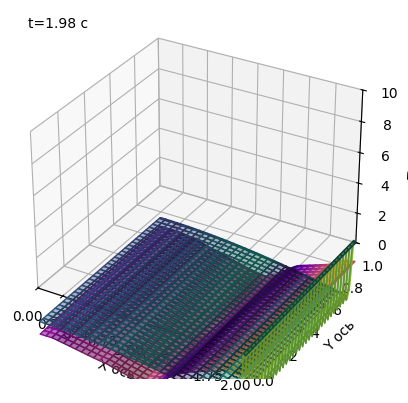

In [67]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.animation import FuncAnimation

fps = 60
duration = 2
slowing = 1

frames = slowing * fps * duration
interval = 1000 / fps * slowing

x = np.linspace(0, 2, 101)
y = np.linspace(0, 1, 101)
t = np.linspace(0, 10, 101)
xv, vy = np.meshgrid(x, y)

# Создание фигуры
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

def wave(frame):
    time = frame / fps
    print(frame, time)

    z = np.array(calculate_func(x, y, time)).reshape(x.shape[0], y.shape[0])
    z_neural = model_func(x, y, time).reshape(x.shape[0], y.shape[0])
    diff = np.abs(z - z_neural)

    ax.clear()
    ax.plot_surface(xv, vy, z, facecolors=plt.cm.viridis(diff/np.max(diff)), alpha=0.4)
    ax.plot_surface(xv, vy, z_neural, facecolors=plt.cm.plasma(diff/np.max(diff)), alpha=0.6)
    ax.set_zlim(0, 10)
    ax.set_xlim(0, 2)
    ax.set_ylim(0, 1)

    ax.set_xlabel("X ось")
    ax.set_ylabel("Y ось")
    ax.set_zlabel("Z ось")

    ax.text2D(0.05, 0.95, f"t={time:.2f} с", transform=ax.transAxes)
    return ax,

ani = FuncAnimation(fig, wave, frames=frames, interval=interval)
ani.save("3d_animation_1.gif", writer='pillow', fps=fps)

plt.show()